In [35]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import numpy as np
from tqdm import tqdm

For each practical exercise (TP), please work in groups of two or three. Then, create a **private GitHub repository** and add me (my GitHub is  **arthur-75**) to your project. Finally, share the link to your project (or TP) under  [Practical Exercises](https://docs.google.com/spreadsheets/d/1V-YKgHn71FnwjoFltDhWsPJS7uIuAh9lj6SP2DSCvlY/edit?usp=sharing) and make sure to choose your **team name** :-)

# **Variational Autoencoders on Fashion MNIST**

## **1: Data Preparation and Visualization**

**Identical to the First Practical Exercise**

**Goal**:

* Load the **Fashion MNIST** dataset and **pad** images to 32×32.  
* Create **DataLoaders** for training and validation.  
* Visualize a few samples to confirm data integrity.

**Key Points to Recall**:

* **Why** do we pad the images from 28×28 to 32×32?  
* **Which** transformations can help (e.g., normalization)?  
* **How** do we shuffle and batch the data for efficient training?

(Refer back to **Step 1** of the first exercise for detailed guidance.)

## **2: Define the VAE Model**

**Key Difference from a Standard Autoencoder**:

* Instead of directly learning a **latent vector** zz, the VAE learns a **distribution** N(μ,σ2)  by predicting **μ**(mean) and **log⁡(σ2)** (log-variance).  
* Use a **reparameterization trick**:

**Guided Outline**:

1. **Encoder**:  
   * Convolutional layers to reduce spatial dimensions and extract features.  
   * Two separate heads: one for **μ** (mean) and one for **log⁡(σ2)**(log-variance).  
2. **Reparameterization** (in a function like `reparameterize(mu, logvar)`).  
3. **Decoder**:  
   * Transposed convolution layers to reconstruct the image from zz.  
   * Output uses **Sigmoid** to ensure pixel values remain between 0 and 1\.

Why do we need separate heads for **μ** and **log⁡(σ2))**?  
How does the reparameterization trick help with backpropagation through stochastic nodes?


In [36]:
class VAE(nn.Module):
    def __init__(self, input_shape=(1, 32, 32), latent_dim=2):
        """
        Variational Autoencoder initialization.
        
        Args:
            input_shape (tuple): Shape of the input image. Default is (1, 32, 32).
            latent_dim (int): Dimension of the latent representation.
        """
        super(VAE, self).__init__()

        # ------------------
        #     1. Encoder
        # ------------------
        # This block progressively reduces the spatial dimension of the input.
        # Each Conv2D layer uses stride=2 to downsample.
        self.encoder = nn.Sequential(
            # First convolutional layer: Convert 1-channel input into 32 feature maps.
            nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, stride=2, padding=1),
            nn.ReLU(), # acivation function 

            # Second convolutional layer: Reduce spatial dimensions further.
            nn.Conv2d(32, 64, kernel_size=3, stride=2, padding=1),
            nn.ReLU(), #acivation function 

            # Third convolutional layer: Extract higher-level features.
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=2, padding=1),  # Add another Conv2D layer with 128 filters, kernel size 3, stride 2, padding 1
            nn.ReLU(), #acivation function 
        )

        # Dynamically calculate the flattened size after all convolution layers
        flattened_size, decode_shape = self.calculate_flattened_size(self.encoder, input_shape)

        # ------------------------------------------------
        #     2. Fully Connected Layers for Latent Space
        # ------------------------------------------------

        # Two separate heads for the VAE:
        #  - fc_mu: Predicts the mean of the latent distribution
        #  - fc_logvar: Predicts the log-variance of the latent distribution
        self.fc_mu = nn.Sequential(
            nn.Flatten(start_dim=1),
            nn.Linear(flattened_size, latent_dim)  # Latent mean
        )
        self.fc_logvar = nn.Sequential(
            nn.Flatten(start_dim=1),
            nn.Linear(flattened_size, latent_dim)  # Latent log variance (Hint: same dimension as mu)
        )

        # ------------------
        #     3. Decoder
        # ------------------
        # Inverts the encoder process with ConvTranspose2d (a.k.a. deconvolutions).
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, flattened_size),  # Map latent space back to the feature map
            nn.Unflatten(decode_shape[0],decode_shape[1:]),  # Reshape to match the encoded feature map

            # Transposed Convolution layers (Decoder)
            nn.ConvTranspose2d(128, 64, kernel_size=3, stride=2, padding=1, output_padding=1), # Add a conv transpose 2d
            nn.ReLU(), # acivation function 


            # Next deconvolution layer
            nn.ConvTranspose2d(64,32,kernel_size=3,stride=2, padding=1, output_padding=1),  # Add a ConvTranspose2d layer reducing from 64 channels to 32 channels and  kernel_size=3, stride=2, padding=1, output_padding=1


            nn.ReLU(), # acivation function 

            # Final deconvolution layer: Convert back to single-channel grayscale image
            nn.ConvTranspose2d(32, 1, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.Sigmoid()  # acivation function Output values should be between 0 and 1
        
        )

        
    def reparameterize(self, mu, logvar):
        """
        Reparameterization trick:
        
        z = mu + sigma * eps, where eps ~ N(0, I)

        Args:
            mu (Tensor): Mean of the latent distribution.
            logvar (Tensor): Log-variance of the latent distribution.

        Returns:
            z (Tensor): Latent variable sampled from N(mu, sigma^2).
        """
        std = torch.exp(0.5 * logvar)  # Convert log variance to standard deviation
        eps = torch.randn_like(std)    # Sample noise from a normal distribution
        return mu + std * eps

    def calculate_flattened_size(self, model, input_shape):
       #same as the last one 
        with torch.no_grad():
            dummy_input = torch.zeros(1, *input_shape)
            output = model(dummy_input)
            return output.numel(), output.shape

    def forward(self, x):
        """
        Forward pass for the VAE:
        
        1) Encode input into latent distribution parameters (mu, logvar).
        2) Sample z using the reparameterization trick.
        3) Decode z back to a reconstructed image.

        Args:
            x (Tensor): Input images.

        Returns:
            recon_x (Tensor): Reconstructed images.
            mu (Tensor): Mean of latent distribution.
            logvar (Tensor): Log-variance of latent distribution.
            z (Tensor): Sampled latent variable.
        """
        # Encode input
        x_encoded = self.encoder(x)

        # Compute mu and logvar
        mu = self.fc_mu(x_encoded)
        logvar = self.fc_logvar(x_encoded)

        # Sample from the latent distribution
        z = self.reparameterize(mu, logvar)

        # Decode latent vector to reconstruct the input
        recon_x = self.decoder(z)
        
        return recon_x, mu, logvar, z


Test

In [37]:
# Test dimension consistency
x_sample = torch.randn(1, 1, 32, 32)  # Example input
model_test = VAE()
image_test, mu, logvar, z = model_test(x_sample)
assert image_test.shape == x_sample.shape, "Output dimensions do not match input dimensions!"

## **3: VAE Loss Function and Training**

1. **VAE Loss** combines:  
   * **Reconstruction Loss** (e.g., Binary Cross Entropy or MSE)  
   * **Kullback–Leibler (KL) Divergence** to regularize the latent space.  
       
2. **β-VAE**:  
   * Introduces a hyperparameter β to **weight the KL term**.  
   * If β=1, it’s the standard VAE.  
   * Larger β puts more emphasis on the KL divergence, often leading to more **disentangled** representations but potentially poorer reconstructions.

### **Training Flow:**

* For each batch:  
  1. Forward pass: get **μ, log⁡(σ2), z,** and **reconstruction**.  
  2. Compute \**vae\_loss \= reconstruction\_loss \+ β.KL\_loss*.  
  3. Backpropagate and **update parameters**.

How does a larger β value change the **trade-off** between **reconstruction quality** and **latent disentanglement**?


In [59]:
#######################
# 1. Define VAE Loss
#######################
def vae_loss(recon_x, x, mu, logvar, beta=1):
    """
    Compute the Variational Autoencoder (VAE) loss function.
    A combination of:
      - Reconstruction loss (using BCE or MSE)
      - KL divergence regularizer

    Args:
      recon_x (Tensor): Reconstructed images from the decoder.
      x (Tensor): Original input images.
      mu (Tensor): Mean of the latent distribution.
      logvar (Tensor): Log-variance of the latent distribution.
      beta (float): Weight for the KL term (β-VAE concept).

    Returns:
      total_loss (Tensor): Sum of reconstruction loss and β * KL divergence.
    """

    # 1) Reconstruction Loss
    #    Measures how closely recon_x matches x. 
    #    Typically use Binary Cross Entropy (BCE) if inputs are normalized [0,1].
    recon_loss = F.binary_cross_entropy(recon_x, x, reduction='sum')


    # 2) KL Divergence
    #    Encourages the approximate posterior (q(z|x)) to be close to a 
    #    standard normal prior p(z) ~ N(0,I).
    kl_div = -0.5 * torch.sum(1 + logvar - mu.pow(2) - torch.exp(logvar))
  
    # Return the total VAE loss
    return recon_loss + beta * kl_div

#######################
# 2. Training Function
#######################
def train_model(model, train_loader, val_loader, epochs, beta=1):
  """
  Trains a VAE model with a given β for the KL term.

  Args:
    model (nn.Module): VAE instance (encoder + decoder).
    train_loader (DataLoader): Dataloader for training set.
    val_loader (DataLoader): Dataloader for validation set.
    epochs (int): Number of training epochs.
    beta (float): Weight for the KL divergence in the VAE loss.
  """

  # Choose an optimizer, e.g., Adam
  optimizer = optim.Adam(model.parameters(), lr=0.0001) # e.g., 1e-4
  # Lists to store loss values for plotting
  train_losses = []
  val_losses = []

  for epoch in range(epochs):
      model.train()  # Set model to train mode
      total_loss = 0
      
      # Use tqdm to create a progress bar
      tqdm_loader = tqdm(train_loader, desc=f"Training Epoch {epoch + 1}/{epochs}")

      for x, _ in tqdm_loader:
          # 1) Zero out gradients from previous iteration
          optimizer.zero_grad()

          # 2) Move the batch to the correct device (CPU, CUDA, or MPS)
          x = x.to(torch.device("cuda" if torch.cuda.is_available() else "cpu"))  # Fill in your device, e.g., device, "cuda", or "mps"

          # 3) Forward pass: encode -> reparameterize -> decode
          recon_x, mu, logvar, _ = model(x)

          # 4) Compute VAE loss
          loss = vae_loss(recon_x, x, mu, logvar, beta=beta)

          # 5) Backpropagation
          loss.backward() # Compute gradients
          # 5) update grad
          optimizer.step()

          # Accumulate total loss for this batch
          total_loss += loss.item()

          # Update tqdm progress bar with the current batch loss
          tqdm_loader.set_postfix(loss=loss.item())

      # Average loss over all training samples
      avg_train_loss = total_loss / len(train_loader.dataset)

      # Evaluate on validation data
      avg_val_loss, _ = evaluate_model(model, val_loader, device=torch.device("cuda" if torch.cuda.is_available() else "cpu"))

      # Print epoch statistics
      print(
          f"Epoch [{epoch + 1}/{epochs}], "
          f"Train Loss: {avg_train_loss:.4f}, "
          f"Val Loss: {avg_val_loss:.4f}"
      )
      train_losses.append(avg_train_loss)
      val_losses.append(avg_val_loss)
  plot_training_loss(train_losses, val_losses)


#######################
# 3. Evaluation Function
#######################
def evaluate_model(model, loader ,beta=1, device=None):
    """
    Evaluates the VAE on a validation or test dataset.

    Args:
      model (nn.Module): VAE instance (encoder + decoder).
      loader (DataLoader): Dataloader for validation/test set.

    Returns:
      avg_loss (float): Average loss across all validation samples.
      ce_loss_placeholder (float): Placeholder if you want to track
                                   additional metrics or losses.
beta (float): Weight for the KL divergence in the VAE loss.
    """
    model.eval()  # Set model to evaluation mode
    total_loss = 0
    ce_loss_placeholder = 0  # Example placeholder for separate metrics

    with torch.no_grad():
        for x, _ in tqdm(loader, desc="Evaluating"):
            x = x.to(device)  # Move data to the same device as the model

            # Forward pass to get reconstruction and latent variables
            recon_x, mu, logvar, _ = model(x)

            # Compute VAE loss (without adjusting gradients)
            loss = vae_loss(recon_x, x, mu, logvar, beta=beta)  # e.g., same β as training

            total_loss += loss.item()
            # Optionally compute or track other metrics here, e.g.:
            # ce_loss_placeholder += some_other_metric(...)

    avg_loss = total_loss / len(loader.dataset)
    return avg_loss, ce_loss_placeholder

def plot_training_loss(train_losses, val_losses):
    """
    Plot the training and validation loss across epochs.

    - train_losses: List of training losses per epoch.
    - val_losses: List of validation losses per epoch.
    """
    plt.figure(figsize=(8, 5))
    plt.plot(train_losses, label="Training Loss", marker="o")
    plt.plot(val_losses, label="Validation Loss", marker="s")
    
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.title("Training vs Validation Loss")
    plt.legend()
    plt.grid()
    plt.show()



Train

In [60]:
# Preprocessing 
transform = transforms.Compose([
  transforms.Pad(2) ,  # Pad 28x28 images to 32x32
  transforms.ToTensor() ,    #Convert images to tensors
])
batch_size = 32

In [61]:
#load data
train_dataset = datasets.FashionMNIST(root="./data", train=True, transform=transform, download=True)
train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
val_dataset = datasets.FashionMNIST(root="./data", train=False, transform=transform, download=True)
val_loader = DataLoader(dataset=val_dataset, batch_size=batch_size, shuffle=True)

In [ ]:
from tqdm import tqdm 
# Train and visualize Autoencoder
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
vae = VAE().to(device)
print("Training Autoencoder...")
train_model(vae, train_loader, val_loader, epochs=20,beta =1.5)

Training Autoencoder...


Training Epoch 1/20:   0%|          | 0/1875 [00:00<?, ?it/s]

Evaluating: 100%|██████████| 313/313 [00:03<00:00, 83.32it/s]


Epoch [1/20], Train Loss: 327.9612, Val Loss: 285.8651


Evaluating: 100%|██████████| 313/313 [00:03<00:00, 89.54it/s]


Epoch [2/20], Train Loss: 282.8880, Val Loss: 277.9099


Evaluating: 100%|██████████| 313/313 [00:03<00:00, 83.12it/s]


Epoch [3/20], Train Loss: 277.7856, Val Loss: 274.6607


Evaluating: 100%|██████████| 313/313 [00:03<00:00, 96.48it/s] 


Epoch [4/20], Train Loss: 275.3021, Val Loss: 273.1711


Evaluating: 100%|██████████| 313/313 [00:03<00:00, 82.78it/s]


Epoch [5/20], Train Loss: 273.6525, Val Loss: 271.9390


Evaluating: 100%|██████████| 313/313 [00:03<00:00, 89.56it/s]


Epoch [6/20], Train Loss: 272.4834, Val Loss: 270.6391


Evaluating: 100%|██████████| 313/313 [00:03<00:00, 89.08it/s]


Epoch [7/20], Train Loss: 271.5292, Val Loss: 269.6761


Evaluating: 100%|██████████| 313/313 [00:03<00:00, 87.28it/s]


Epoch [8/20], Train Loss: 270.7876, Val Loss: 269.3205


Evaluating: 100%|██████████| 313/313 [00:03<00:00, 93.86it/s]


Epoch [9/20], Train Loss: 270.1122, Val Loss: 268.5583


Evaluating: 100%|██████████| 313/313 [00:03<00:00, 95.50it/s] 


Epoch [10/20], Train Loss: 269.5796, Val Loss: 268.0855


Evaluating: 100%|██████████| 313/313 [00:03<00:00, 95.82it/s] 


Epoch [11/20], Train Loss: 269.0440, Val Loss: 267.4923


Evaluating: 100%|██████████| 313/313 [00:03<00:00, 95.60it/s] 


Epoch [12/20], Train Loss: 268.6018, Val Loss: 267.1640


Evaluating: 100%|██████████| 313/313 [00:03<00:00, 79.36it/s]


Epoch [13/20], Train Loss: 268.2344, Val Loss: 266.6564


Evaluating: 100%|██████████| 313/313 [00:03<00:00, 91.90it/s]


Epoch [14/20], Train Loss: 267.8558, Val Loss: 266.5010


Training Epoch 15/20:  24%|██▍       | 453/1875 [00:09<00:29, 48.26it/s, loss=9.43e+3]

#### You must at least run one epoch and then load this pre-trained model:

In [ ]:
# Load state dictionariespath= "path"model.load_state_dict(torch.load(path, map_location=DEVICE))model.eval()

## **4: Reconstruct Images**

**Similar to Step 4 in the First Practical Exercise**

**Goal**:

* Take a batch of **original images**.  
* Pass them through the VAE to get **reconstructed images**.  
* Plot and compare **side-by-side**.

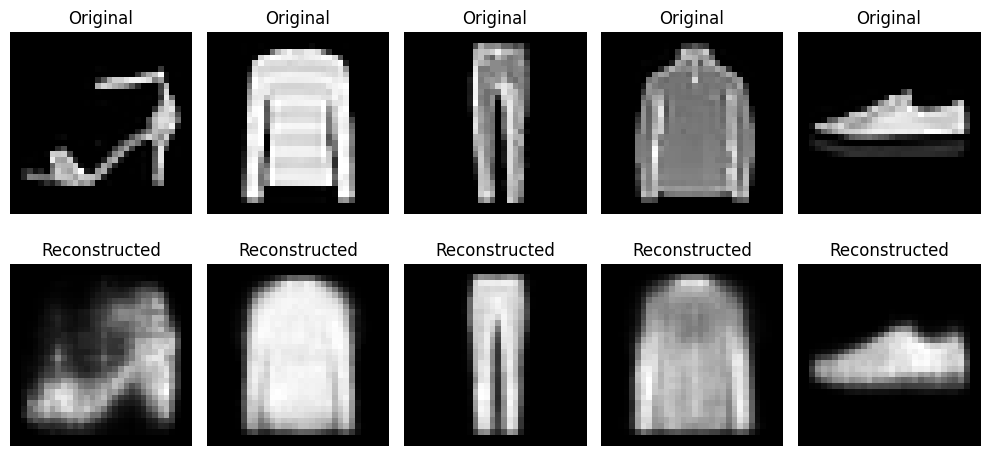

In [45]:
def plot_reconstructions(model, loader_or_z, ex=True, num_samples=5):
    """
    Plot original and reconstructed images from an Autoencoder (VAE).

    Parameters:
    - model: Trained VAE model.
    - loader_or_z: Either a DataLoader (for real images) or sampled latent vectors.
    - ex: If True, extracts a batch from DataLoader; otherwise, uses provided latent vectors.
    - num_samples: Number of images to display.

    """
    model.eval()  # Set model to evaluation mode
    model = model.to("cpu")  # Move to CPU for visualization

    with torch.no_grad():
        if ex:  # Extract batch from DataLoader
            for x, _ in loader_or_z:
                recon_x, _, _, _ = model(x)
                break
        else:  # Use provided latent vectors
            x = None  # No original images in this case
            recon_x = model.decoder(loader_or_z)

    # Convert tensors to NumPy for visualization
    if x is not None:
        x = x.cpu().numpy()
    recon_x = recon_x.cpu().numpy()

    plt.figure(figsize=(10, 5))
    for i in range(num_samples):
        # Plot Original images (if real data was used)
        if x is not None:
            plt.subplot(2, num_samples, i + 1)
            plt.imshow(x[i].squeeze(), cmap="gray")
            plt.title("Original")
            plt.axis("off")

        # Plot Reconstructed images
        plt.subplot(2, num_samples, i + 1 + num_samples)
        plt.imshow(recon_x[i].squeeze(), cmap="gray")
        plt.title("Reconstructed")
        plt.axis("off")

    plt.tight_layout()
    plt.show()
plot_reconstructions( vae, train_loader, ex=True)





## **5: Visualize the Latent Space**

**Similar to Step 5 in the First Practical Exercise**

**Goal**:

* Extract **2D latent embeddings** by forwarding images through the encoder.  
* Plot them in a 2D scatter plot, color-coded by labels.

In [50]:
embeddings = []
labels = []

vae = vae.to(device)  # Replace xxx with the correct device 
with torch.no_grad():
    for x, y in train_loader:  # Iterate over training batches
        x = x.to(device)  # Move batch to device

        _, _, _, latent = vae.forward(x) # Forward pass through VAE

        # Convert to NumPy and store results
        embeddings.append(latent.cpu().numpy())
        labels.append(y.numpy())

embeddings = np.concatenate(embeddings, axis=0)  
labels = np.concatenate(labels, axis=0)  

# Identify unique class labels
unique_labels = np.unique(labels)
vae=vae.to("cpu")

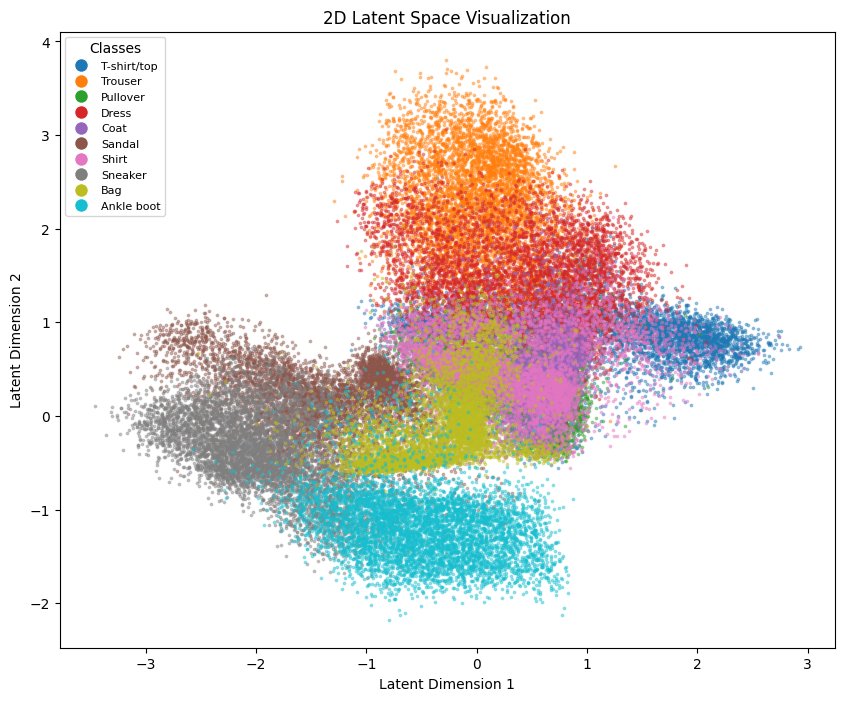

In [51]:
#Plot the 2D embeddings
class_labels = {
    0: 'T-shirt/top', 1: 'Trouser', 2: 'Pullover', 3: 'Dress', 4: 'Coat',
    5: 'Sandal', 6: 'Shirt', 7: 'Sneaker', 8: 'Bag', 9: 'Ankle boot'
}

colors = plt.cm.tab10(np.linspace(0, 1, len(unique_labels)))

#Scatter plot
plt.figure(figsize=(10, 8))
legend_handles = []
for i, label in enumerate(unique_labels):
    indices = np.where(labels == label)[0]
    scatter = plt.scatter(
        embeddings[indices, 0], embeddings[indices, 1],
        c=[colors[i]], alpha=0.4, s=3, label=class_labels[label]
    )
    legend_handles.append(
        Line2D([0], [0], marker='o', color='w', label=f'{class_labels[label]}',
               markersize=10, markerfacecolor=colors[i])
    )

plt.xlabel('Latent Dimension 1')
plt.ylabel('Latent Dimension 2')
plt.title('2D Latent Space Visualization')
plt.legend(handles=legend_handles, title='Classes', loc='upper left', fontsize=8)
plt.show()



## **6: Generate New Images**

**Similar to Step 6 in the First Practical Exercise**

**Goal**:

* Sample random points zz from a **Gaussian distribution** (e.g., N(0,I)) or from the learned ranges of μ and log⁡(σ2)).  
* Pass these points through the **decoder**.  
* Observe the generated images.

tensor([[-0.7638,  0.2935],
        [ 0.2374, -0.2039],
        [ 0.0980,  0.1482],
        [-0.0419, -1.0753],
        [-2.7253, -1.2486]])


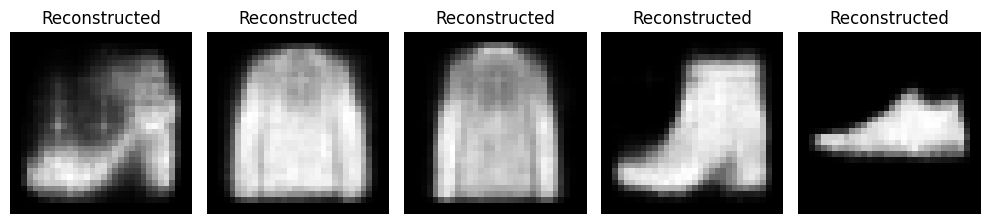

In [ ]:
z_sample =  torch.tensor(np.random.normal(size=(5, 2)),dtype=torch.float32)
print(z_sample) 

plot_reconstructions( vae, z_sample, ex=False)

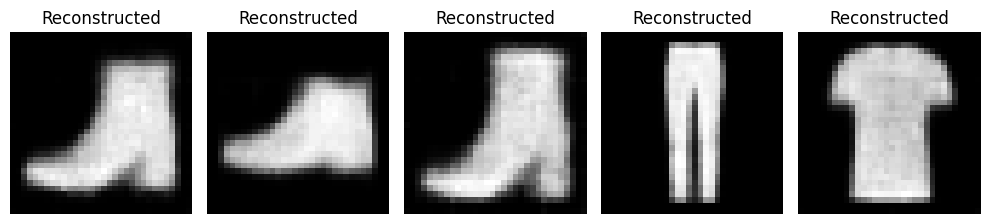

In [ ]:
x_sample = torch.tensor([[0.,-1.5],[-1.,-1],[0.5,-1.5],[0,3],[2,1]])# Example input
plot_reconstructions(vae, x_sample, ex=False)
